# **Instrumental Variables**

**Notes:**

- Better suited for **unmeasured confounders** `U` that affect both the treament `A` and the outcome `Y `. Measured confounders `X`.
    - If there's unmeasured confounding, we cannot marginalize over all confounders (via matching, iptw, etc)
    - Focuses on the **Local Average Treatment Effect** `LATE` aka **Complier Average Causal Effect** `CACE`
    - This is different from the **Average Causal Effect for the Population** `ATE`, and the **Average Causal Effect for the Treated** `ATT` aka **Intention-to-Treat Effect** `ITT`.
    - [Reference](https://www.jpsmjournal.com/article/S0885-3924(16)30111-7/pdf#:~:text=ATE%20%3D%20average%20treatment%20effect%3B%20ATT,%3D%20person%2Dcentered%20treatment%20effect.)
- We could use an instrumental variable `Z`, which affects the treatment, but not directly affect the outcome (exclusion restriction). `Z` is also considered **encouragement**.
    - Assumptions have to be carefully validated, especially the **exclusion restriction**.
- An **intention-to-treat** analysis would focus on the causal effect of encouragement.


**Randomized trials with non-compliance**

- `Z`: randomization to treatment
- `A`: actual treatment received
- `Y`: outcome
- Average Causal Effect of Treatment Assignment on Treatment Received
- Average Causal Effect of Treatment Assignment on Outcome: **Intention-to-Treat Effect**

**Compliance Classes**

|  A<sup>0</sup> |  A<sup>1</sup> |  Segment |
|---|---|---|
| 0  | 0 | Never-takers |
| 0  | 1 | Compliers  |
| 1  | 0 |  Defiers |
| 1  | 1 | Always-takers  |

- May have to assume who are never-takers and always-takers, can't learn anything about causal effect on those sub-populations.
- aka **Principal Strata**, they're latent, and not directly observable.
- **Monotonicity assumption**: no defiers, probability of treatment should increase with more encouragement.
- In case of perfect compliance `CACE = LATE = ATT = ITT`, otherwise `LATE = ATT/P(compliers)` or `CACE = ITT/P(compliers)`
- Strength of an IV can be measured by the proportion of compliers. If strength is low, it can lead to large variance estimates.


**Two Stage Least Squares**

- `Stage 1`: Regress `A` on `Z` and covariates `X`
- `Stage 2`: Regress `Y` on `A^` and covariates `X`
    - Coefficient of `A^` is the causal effect.

In [17]:
#install needed libraries
install.packages("ivpack")

Installing package into ‘/home/starscream/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



## **Load Libraries and Data**

In [18]:
library(ivpack)

In [16]:
data <- read.csv( "assets/Mroz.csv")
head(data)

,X,work,hoursw,child6,child618,agew,educw,hearnw,wagew,hoursh,ageh,educh,wageh,income,educwm,educwf,unemprate,city,experience
,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<chr>,<int>
1,1,yes,1610,1,0,32,12,3.3540,2.65,2708,34,12,4.0288,16310,12,7,5.0,no,14
2,2,yes,1656,0,2,30,12,1.3889,2.65,2310,30,9,8.4416,21800,7,7,11.0,yes,5
3,3,yes,1980,1,3,35,12,4.5455,4.04,3072,40,12,3.5807,21040,12,7,5.0,no,15
4,4,yes,456,0,3,34,12,1.0965,3.25,1920,53,10,3.5417,7300,7,7,5.0,no,6
5,5,yes,1568,1,2,31,14,4.5918,3.60,2000,32,12,10.0000,27300,12,14,9.5,yes,7
6,6,yes,2032,0,0,54,12,4.7421,4.70,1040,57,11,6.7106,19495,14,7,7.5,yes,33


[1] 12.49137

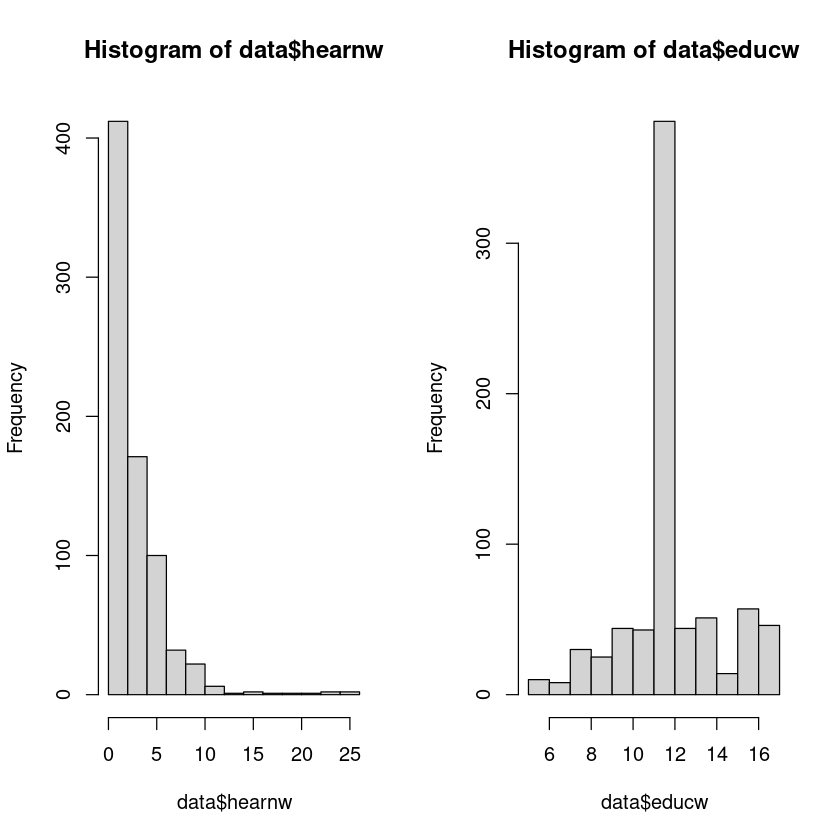

In [21]:
# IV is educh (husband's education)
# outcome is hearnw (wife's average hourly earnings)
#'treatment' is educw (wife's number of years of education)
mean(data$educh)
par(mfrow=c(1,2))
hist(data$hearnw)
hist(data$educw)

In [25]:
#is the IV associated with the treatment? strenght of IV
mean(data$educw[data$educh>=mean(data$educh)])
mean(data$educw[data$educh<mean(data$educh)])

[1] 13.77966

[1] 11.32533

In [45]:
#make education binary
b_educw <- data$educw>=mean(data$educw)
b_educh <- data$educh>=mean(data$educh)

#estimate proportion of 'compliers'
p_compliers <- mean(b_educw[b_educh == 1])-
  mean(b_educw[b_educh == 0])
p_compliers

[1] 0.4901414

##  **Intention To Treat Effect [ITT]**

In [46]:
itt <- mean(data$hearnw[b_educh == 1])-
  mean(data$hearnw[b_educh == 0])
itt

[1] 0.7017135

## **Complier Average Causal Effect [CACE]**

`CACE = ITT/P(compliers)`

In [47]:
itt/p_compliers

[1] 1.431655

## **Two Stage Least Squares**

### **Stage 1: Regress A on Z**

In [48]:
model_s1 <- lm(b_educw~b_educh)
## get predicted value of A given Z for each subject
pred_s1 <- predict(model_s1, type = "response")
table(pred_s1)

pred_s1
0.0895196506550205  0.579661016949152 
               458                295 

### **Stage 2: Regress Y on predicted value of A**

In [49]:
model_s2 <- lm(data$hearnw~pred_s1)
model_s2


Call:
lm(formula = data$hearnw ~ pred_s1)

Coefficients:
(Intercept)      pred_s1  
      1.971        1.432  


In [51]:
#2SLS using ivpack
ivmodel = ivreg(hearnw ~ b_educw, ~ b_educh, x=TRUE, data=data)
robust.se(ivmodel)

[1] "Robust Standard Errors"



t test of coefficients:

            Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  1.97150    0.16980 11.6104 < 2.2e-16 ***
b_educwTRUE  1.43166    0.49061  2.9181  0.003627 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [56]:
#2SLS using ivpack
ivmodel = ivreg(hearnw ~ b_educw + ageh + agew + child6 + child618 + experience + unemprate, ~ b_educh + ageh + agew + child6 + child618 + experience + unemprate, x=TRUE, data=data)
robust.se(ivmodel)

[1] "Robust Standard Errors"



t test of coefficients:

              Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  4.4882471  0.9102768  4.9306 1.011e-06 ***
b_educwTRUE  1.5062626  0.4639772  3.2464  0.001221 ** 
ageh        -0.0017740  0.0273815 -0.0648  0.948360    
agew        -0.0760981  0.0302200 -2.5181  0.012006 *  
child6      -1.0927623  0.2223556 -4.9145 1.095e-06 ***
child618    -0.0379585  0.0938613 -0.4044  0.686026    
experience   0.1083748  0.0137714  7.8695 1.254e-14 ***
unemprate   -0.0071477  0.0341777 -0.2091  0.834401    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
